In [16]:
import rasterio as rio
from rasterio.plot import show
import ultraplot as uplt
import cartopy.io.img_tiles as cimgt
import cartopy.crs as ccrs
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.transform import array_bounds
import numpy as np
from matplotlib.colors import  ListedColormap
import matplotlib.patches as mpatches

In [2]:
data_2023 = rio.open('./Data/cary_2023.tif')

In [3]:
data_2024 = rio.open('./Data/cary_2024.tif')

In [4]:
dest_crs = ccrs.AlbersEqualArea(central_longitude=-76.0, central_latitude=42.0,)

def prepare_for_viz(raster_file, dest_crs, mask_polygon=None):
    if mask_polygon is not None:
        orig_image, orig_transform = rmask.mask(raster_file, [mask_polygon], crop=True)
    else:
        orig_image = raster_file.read()
        orig_transform = raster_file.transform
        
    transform, width, height = calculate_default_transform(
        raster_file.crs, dest_crs, raster_file.width, raster_file.height, *raster_file.bounds)
    
    new_image, new_transform = reproject(
        source=orig_image,
        src_transform=orig_transform,
        src_crs=raster_file.crs,
        dst_crs=dest_crs,
        resampling=Resampling.nearest,
        dst_nodata=100)
    print(new_transform)
    new_image = new_image.astype(np.float64)
    new_image[new_image == 100] = np.nan
    new_image[new_image == 0] = np.nan
    
    new_bounds = array_bounds(new_image.shape[1], new_image.shape[2], new_transform)

    return new_image, new_bounds

cary_2023, cary_2023_bounds = prepare_for_viz(data_2023, dest_crs)
cary_2024, cary_2024_bounds = prepare_for_viz(data_2024, dest_crs)

| 10.13, 0.00, 179393.31|
| 0.00,-10.13,-19059.37|
| 0.00, 0.00, 1.00|
| 10.13, 0.00, 179393.31|
| 0.00,-10.13,-19059.37|
| 0.00, 0.00, 1.00|


In [13]:
two_years = ((cary_2024 == 1) & (cary_2023 == 1)).astype(float)
two_years = np.where(two_years, two_years, np.nan)
only_2023 = (~(cary_2024 == 1) & (cary_2023 == 1)).astype(float)
only_2023 = np.where(only_2023, only_2023, np.nan)
only_2024 = ((cary_2024 == 1) & ~(cary_2023 == 1)).astype(float)
only_2024 = np.where(only_2024, only_2024, np.nan)

C:\Users\camer\AppData\Local\Temp\ipykernel_20800\93846945.py:6: UltraPlotWarning: Calling arbitrary axes methods from SubplotGrid was deprecated in v0.8 and will be removed in a future release. Please index the grid or loop over the grid instead.
  axes.set_extent(bounds_rearranged, crs=dest_crs)
C:\Users\camer\AppData\Local\Temp\ipykernel_20800\93846945.py:8: UltraPlotWarning: Calling arbitrary axes methods from SubplotGrid was deprecated in v0.8 and will be removed in a future release. Please index the grid or loop over the grid instead.
  axes.add_image(background, 14)


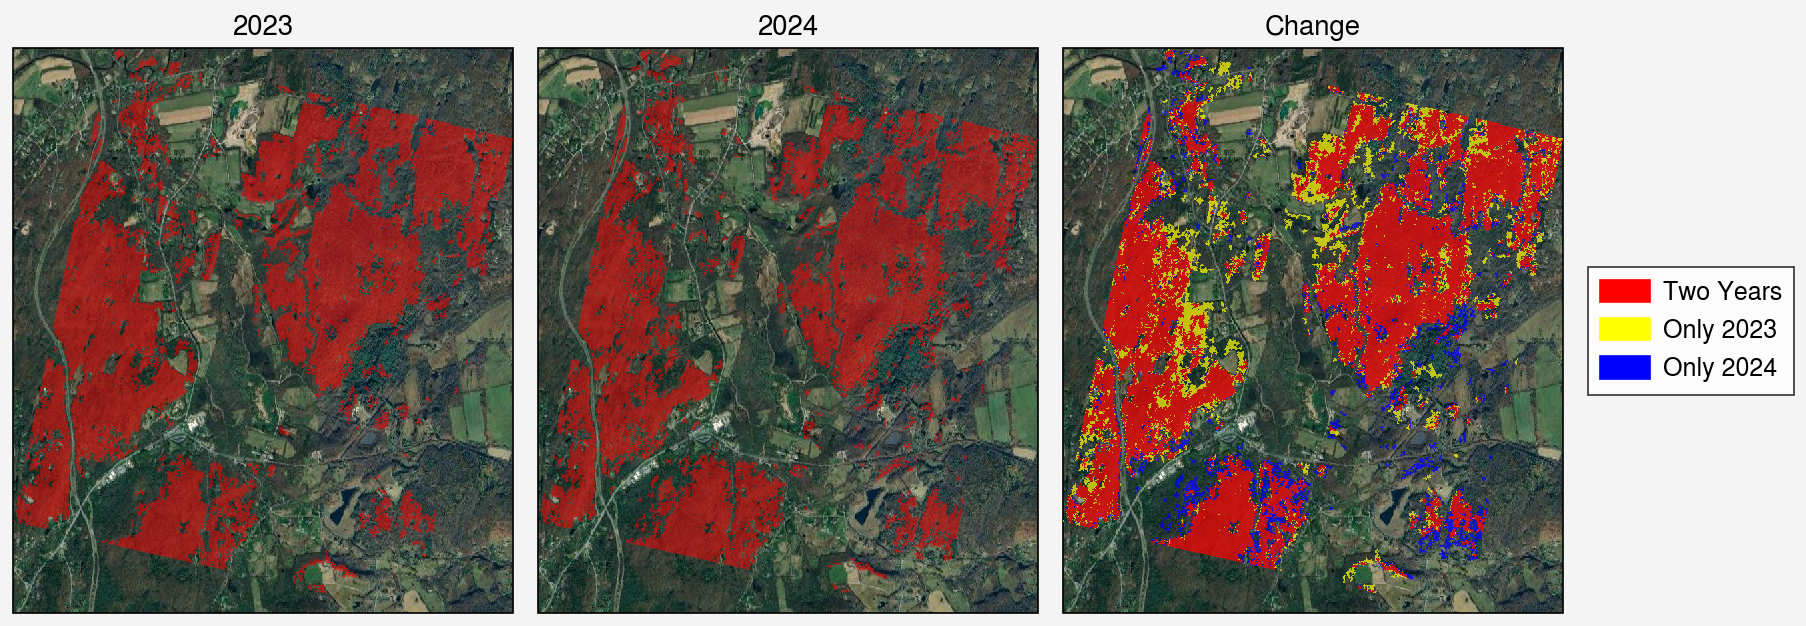

In [20]:
fig, axes = uplt.subplots(ncols=3, proj=dest_crs)

background = cimgt.GoogleTiles(style='satellite')

bounds_rearranged = [cary_2023_bounds[i] for i in [0, 2, 1, 3]]
axes.set_extent(bounds_rearranged, crs=dest_crs)

axes.add_image(background, 14)

cmap = ListedColormap(["red"])
axes[0].imshow(cary_2023[0], extent=bounds_rearranged, 
              origin='upper', transform=dest_crs, zorder=10, cmap=cmap, alpha = 0.5)
axes[0].format(title='2023')

axes[1].imshow(cary_2024[0], extent=bounds_rearranged, 
              origin='upper', transform=dest_crs, zorder=10, cmap=cmap, alpha = 0.5)

axes[1].format(title='2024')

two_years_cmap = ListedColormap(["red"])
only_2023_cmap = ListedColormap(["yellow"])
only_2024_cmap = ListedColormap(["blue"])
axes[2].imshow(two_years[0], extent=bounds_rearranged, 
              origin='upper', transform=dest_crs, zorder=10, cmap=two_years_cmap, alpha = 0.7)
axes[2].imshow(only_2023[0], extent=bounds_rearranged, 
              origin='upper', transform=dest_crs, zorder=10, cmap=only_2023_cmap, alpha = 0.7)
axes[2].imshow(only_2024[0], extent=bounds_rearranged, 
              origin='upper', transform=dest_crs, zorder=10, cmap=only_2024_cmap, alpha = 0.7)
axes[2].format(title='Change')


two_years_patch = mpatches.Patch(color='red', label='Two Years')
only_2023_patch = mpatches.Patch(color='yellow', label='Only 2023')
only_2024_patch = mpatches.Patch(color='blue', label='Only 2024')
fig.legend(handles=[two_years_patch, only_2023_patch, only_2024_patch], loc='r', ncols=1)